<a href="https://colab.research.google.com/github/hanguyenai/sudo-code-nlp/blob/main/06_machine_translation/EVBCorpus_English_Vietnamese_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Importing dependencies

In [ ]:
!pip install sacrebleu sentencepiece torchtext rarfile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.6 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import math
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
from tqdm import tqdm
import sacrebleu
from pathlib import Path
import pickle
import os
import urllib.request
from pathlib import Path
import rarfile
import xml.etree.ElementTree as ET
import pandas as pd
from bs4 import BeautifulSoup

In [ ]:
# Special tokens
PAD = '<pad>'
UNK = '<unk>'
BOS = '<sos>'
EOS = '<eos>'

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
!git clone https://github.com/qhungngo/EVBCorpus.git

Cloning into 'EVBCorpus'...
remote: Enumerating objects: 35, done.
remote: Total 35 (delta 0), reused 0 (delta 0), pack-reused 35 (from 1)
Receiving objects: 100% (35/35), 35.37 MiB | 41.11 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [ ]:
def parse_sgml_file(sgml_path):
    """Parse a single SGML file and extract English-Vietnamese sentence pairs"""
    try:
        # Read file content
        with open(sgml_path, 'r', encoding='utf-8') as f:
            content = f.read()

        # Parse with BeautifulSoup (handles SGML/XML-like formats)
        soup = BeautifulSoup(content, 'html.parser')

        pairs = []

        # Find all sentence pairs
        for spair in soup.find_all('spair'):
            en_text = ""
            vi_text = ""

            # Get all <s> tags in this spair
            s_tags = spair.find_all('s')

            for s in s_tags:
                s_id = s.get('id', '')
                text = s.get_text(strip=True)

                # Identify English vs Vietnamese by id prefix
                if s_id.startswith('en'):
                    en_text = text
                elif s_id.startswith('vn'):
                    vi_text = text

            # Only add if both sentences exist and are non-empty
            if en_text and vi_text:
                pairs.append({
                    'english': en_text,
                    'vietnamese': vi_text
                })

        return pairs

    except Exception as e:
        print(f"⚠️  Error parsing {os.path.basename(sgml_path)}: {e}")
        return []

In [ ]:
def load_evbcorpus_to_dataframe(extract_dir):
    """Load all SGML files from EVBCorpus and create pandas DataFrame"""
    print("\n📖 Parsing SGML files...")

    # Find all SGML/XML files
    sgml_files = []
    for root, dirs, files in os.walk(extract_dir):
        for f in files:
            if f.endswith('.xml') or f.endswith('.sgml'):
                sgml_files.append(os.path.join(root, f))

    if not sgml_files:
        print("⚠️  No SGML/XML files found!")
        print(f"Searched in: {extract_dir}")
        print("\nTrying to find all files...")
        all_files = []
        for root, dirs, files in os.walk(extract_dir):
            all_files.extend([os.path.join(root, f) for f in files[:5]])
        print(f"Found files: {all_files[:10]}")
        raise FileNotFoundError("No SGML/XML files found in extracted directory")

    print(f"Found {len(sgml_files)} SGML/XML files")

    # Parse all SGML files
    all_pairs = []
    from tqdm import tqdm

    for sgml_file in tqdm(sgml_files, desc="Parsing SGML"):
        pairs = parse_sgml_file(sgml_file)
        all_pairs.extend(pairs)

    if not all_pairs:
        raise ValueError("No sentence pairs found! Check SGML file format.")

    # Create DataFrame
    df = pd.DataFrame(all_pairs)

    # Remove duplicates
    df = df.drop_duplicates()

    print(f"\n✓ Loaded {len(df):,} sentence pairs")
    print(f"  Unique pairs: {len(df):,}")
    print(f"\nDataFrame Info:")
    print(f"  Shape: {df.shape}")
    print(f"  Columns: {df.columns.tolist()}")

    # Show statistics
    print(f"\nSentence Length Statistics:")
    df['en_words'] = df['english'].str.split().str.len()
    df['vi_words'] = df['vietnamese'].str.split().str.len()
    print(f"  English words: mean={df['en_words'].mean():.1f}, max={df['en_words'].max()}")
    print(f"  Vietnamese words: mean={df['vi_words'].mean():.1f}, max={df['vi_words'].max()}")

    # Drop temporary columns
    df = df.drop(['en_words', 'vi_words'], axis=1)

    return df

In [ ]:
rar_path = "/content/EVBCorpus/EVBCorpus_EVBNews_v2.0.rar"
out_dir = "/content/evbcorpus_data/EVBCorpus_v2"
os.makedirs(out_dir, exist_ok=True)

with rarfile.RarFile(rar_path) as rf:
    # rf.printdir()  # xem list file
    rf.extractall(path=out_dir)

In [ ]:
# Download and parse corpus
print("=" * 80)
print("EVBCorpus v2.0 - SGML Parser")
print("=" * 80)

extract_dir = out_dir
corpus_df = load_evbcorpus_to_dataframe(extract_dir)

# Display sample data
print("\n📊 Sample data from DataFrame:")
print("=" * 80)
display_df = corpus_df.head(5).copy()
display_df['english'] = display_df['english'].str[:60] + '...'
display_df['vietnamese'] = display_df['vietnamese'].str[:60] + '...'
print(display_df.to_string(index=True))
print("\n" + "=" * 80)

EVBCorpus v2.0 - SGML Parser

📖 Parsing SGML files...
Found 1000 SGML/XML files


Parsing SGML: 100%|██████████| 1000/1000 [00:13<00:00, 75.10it/s]



✓ Loaded 43,695 sentence pairs
  Unique pairs: 43,695

DataFrame Info:
  Shape: (43695, 2)
  Columns: ['english', 'vietnamese']

Sentence Length Statistics:
  English words: mean=19.6, max=149
  Vietnamese words: mean=26.8, max=185

📊 Sample data from DataFrame:
                                                           english                                                       vietnamese
0  Baby development : 12 ways to help your infant learn and gro...  Sự phát triển của trẻ : 12 cách để giúp trẻ sơ sinh nhận thứ...
1                                                     One month...                                                  1 tháng tuổi...
2                        Spend time with your baby , up close ....  Ở giai đoạn này bạn nên dành thời gian với con , ở gần sát b...
3                                                         Why ?...                                                   Tại sao ư ?...
4  She sees best now when things are only 8 to 15 inches away ....  Bé của b

In [ ]:
def preprocess_sentence(w, max_length=None):
    """Preprocess a sentence (TensorFlow/Keras style)"""
    w = w.lower().strip()

    # Add space around punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # Replace multiple spaces with single space
    w = re.sub(r'\s+', ' ', w)
    w = w.strip()

    # Truncate to max_length if specified
    if max_length:
        w = " ".join(w.split()[:max_length])

    # Add start and end tokens
    w = '{} {} {}'.format(BOS, w, EOS)

    return w

In [ ]:
def display_samples(inp_lines, targ_lines, num_of_pairs=5):
    """Display sample data pairs"""
    pairs = list(zip(inp_lines[:num_of_pairs], targ_lines[:num_of_pairs]))

    print('=' * 70)
    print('SAMPLE DATA')
    print('=' * 70)

    for i, (inp, targ) in enumerate(pairs):
        print(f'\n--> Sample {i + 1}:')
        print(f'    Input:  {inp}')
        print(f'    Target: {targ}')

    print('\n' + '=' * 70)

In [ ]:
def load_data_from_dataframe(df, max_samples=None, max_length=100):
    """Load and preprocess data from pandas DataFrame"""
    print(f"\n📖 Loading data from DataFrame...")
    print(f"  Total pairs: {len(df):,}")

    # Get English and Vietnamese sentences
    en_sentences = df['english'].tolist()
    vi_sentences = df['vietnamese'].tolist()

    print(f"\n🧹 Preprocessing sentences...")
    en_preprocessed = []
    vi_preprocessed = []

    for en, vi in tqdm(zip(en_sentences, vi_sentences), total=len(en_sentences), desc="Processing"):
        en_prep = preprocess_sentence(en, max_length=max_length)
        vi_prep = preprocess_sentence(vi, max_length=max_length)

        # Filter out empty sentences
        if len(en_prep.split()) > 2 and len(vi_prep.split()) > 2:  # More than BOS+EOS
            en_preprocessed.append(en_prep)
            vi_preprocessed.append(vi_prep)

    print(f"✓ After preprocessing: {len(en_preprocessed):,} sentences")

    if max_samples:
        en_preprocessed = en_preprocessed[:max_samples]
        vi_preprocessed = vi_preprocessed[:max_samples]
        print(f"✓ Using {max_samples:,} samples")

    # Display samples
    display_samples(en_preprocessed, vi_preprocessed, num_of_pairs=3)

    return en_preprocessed, vi_preprocessed

In [ ]:
class Tokenizer:
    """Tokenizer similar to TensorFlow/Keras Tokenizer"""
    def __init__(self, num_words=None, oov_token='<unk>'):
        self.num_words = num_words
        self.oov_token = oov_token

        self.word_index = {}  # word -> index mapping
        self.index_word = {}  # index -> word mapping
        self.word_counts = Counter()

        # Initialize with special tokens
        self.word_index = {
            PAD: 0,
            BOS: 1,
            EOS: 2,
            UNK: 3
        }
        self.index_word = {v: k for k, v in self.word_index.items()}

    def fit_on_texts(self, texts):
        """Build vocabulary from texts"""
        print(f"🔧 Building vocabulary...")

        # Count words
        for text in tqdm(texts, desc="Counting words"):
            words = text.split()
            self.word_counts.update(words)

        # Build word_index based on frequency
        sorted_words = sorted(self.word_counts.items(), key=lambda x: x[1], reverse=True)

        # Start from index 4 (after special tokens)
        idx = 4
        for word, count in sorted_words:
            if word not in self.word_index:
                if self.num_words is None or idx < self.num_words:
                    self.word_index[word] = idx
                    self.index_word[idx] = word
                    idx += 1

        vocab_size = len(self.word_index)
        print(f"✓ Vocabulary size: {vocab_size:,}")
        print(f"  Total unique words: {len(self.word_counts):,}")
        if self.num_words:
            print(f"  Kept top {self.num_words:,} words")

    def texts_to_sequences(self, texts):
        """Convert texts to sequences of integers"""
        sequences = []
        for text in texts:
            words = text.split()
            sequence = []
            for word in words:
                if word in self.word_index:
                    sequence.append(self.word_index[word])
                else:
                    sequence.append(self.word_index[UNK])
            sequences.append(sequence)
        return sequences

    def sequences_to_texts(self, sequences):
        """Convert sequences of integers back to texts"""
        texts = []
        for sequence in sequences:
            words = []
            for idx in sequence:
                if idx in self.index_word:
                    word = self.index_word[idx]
                    # Skip special tokens except for visualization
                    if word not in [PAD, BOS, EOS]:
                        words.append(word)
                else:
                    words.append(UNK)
            texts.append(' '.join(words))
        return texts

    def get_vocab_size(self):
        """Get vocabulary size"""
        return len(self.word_index)

    def save(self, filepath):
        """Save tokenizer"""
        with open(filepath, 'wb') as f:
            pickle.dump({
                'word_index': self.word_index,
                'index_word': self.index_word,
                'word_counts': self.word_counts,
                'num_words': self.num_words,
                'oov_token': self.oov_token
            }, f)

    def load(self, filepath):
        """Load tokenizer"""
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
            self.word_index = data['word_index']
            self.index_word = data['index_word']
            self.word_counts = data['word_counts']
            self.num_words = data['num_words']
            self.oov_token = data['oov_token']

In [ ]:
class TranslationDataset(Dataset):
    """Dataset for translation task"""
    def __init__(self, src_sequences, trg_sequences, max_len=None):
        self.src_sequences = src_sequences
        self.trg_sequences = trg_sequences
        self.max_len = max_len

    def __len__(self):
        return len(self.src_sequences)

    def __getitem__(self, idx):
        src = self.src_sequences[idx]
        trg = self.trg_sequences[idx]

        # Truncate if too long
        if self.max_len:
            src = src[:self.max_len]
            trg = trg[:self.max_len]

        src = torch.tensor(src, dtype=torch.long)
        trg = torch.tensor(trg, dtype=torch.long)
        return src, trg

In [ ]:
def collate_fn(batch):
    """Collate function for DataLoader with padding"""
    src_batch, trg_batch = zip(*batch)

    # Pad sequences
    src_batch = nn.utils.rnn.pad_sequence(src_batch, batch_first=True, padding_value=0)
    trg_batch = nn.utils.rnn.pad_sequence(trg_batch, batch_first=True, padding_value=0)

    return src_batch, trg_batch

In [ ]:
class PositionalEncoding(nn.Module):
    """Positional encoding for Transformer"""
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # FIX: Use torch.arange instead of torch.range (deprecated)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Add positional encoding and apply dropout
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [ ]:
class TransformerTranslator(nn.Module):
    """Transformer model for translation"""
    def __init__(self, src_vocab_size, trg_vocab_size, d_model=512, nhead=8,
                 num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048,
                 dropout=0.1, max_len=200):
        super(TransformerTranslator, self).__init__()

        self.d_model = d_model
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.trg_embedding = nn.Embedding(trg_vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_len, dropout=dropout)

        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )

        self.fc_out = nn.Linear(d_model, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)

        self._init_weights()

    def _init_weights(self):
        """Initialize weights"""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def generate_square_subsequent_mask(self, sz):
        """Generate mask for target sequence"""
        mask = torch.triu(torch.ones(sz, sz), diagonal=1).bool()
        return mask

    def forward(self, src, trg):
        """Forward pass"""
        # Create masks
        trg_mask = self.generate_square_subsequent_mask(trg.size(1)).to(src.device)
        src_padding_mask = (src == 0)
        trg_padding_mask = (trg == 0)

        # Embeddings with scaling
        src_emb = self.pos_encoder(self.src_embedding(src) * math.sqrt(self.d_model))
        trg_emb = self.pos_encoder(self.trg_embedding(trg) * math.sqrt(self.d_model))

        # Transformer
        output = self.transformer(
            src_emb, trg_emb,
            tgt_mask=trg_mask,
            src_key_padding_mask=src_padding_mask,
            tgt_key_padding_mask=trg_padding_mask
        )

        return self.fc_out(output)

In [ ]:
def train_epoch(model, dataloader, optimizer, criterion, clip=1.0):
  """Train for one epoch"""
  model.train()
  epoch_loss = 0
  progress_bar = tqdm(dataloader, desc="Training")
  for src, trg in progress_bar:
    src, trg = src.to(device), trg.to(device)

    optimizer.zero_grad()

    # Forward pass
    output = model(src, trg[:, :-1])

    # Reshape for loss calculation
    output = output.reshape(-1, output.shape[-1])
    trg = trg[:, 1:].reshape(-1)

    loss = criterion(output, trg)
    loss.backward()

    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

    optimizer.step()
    epoch_loss += loss.item()
    progress_bar.set_postfix({'loss': loss.item()})

  return epoch_loss / len(dataloader)

In [ ]:
def evaluate(model, dataloader, criterion):
    """Evaluate model"""
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for src, trg in tqdm(dataloader, desc="Evaluating"):
            src, trg = src.to(device), trg.to(device)

            output = model(src, trg[:, :-1])
            output = output.reshape(-1, output.shape[-1])
            trg = trg[:, 1:].reshape(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

In [ ]:
def translate_sentence(model, sentence, src_tokenizer, trg_tokenizer, max_len=50):
    """Translate a single sentence"""
    model.eval()

    # Preprocess and tokenize source sentence
    preprocessed = preprocess_sentence(sentence, max_length=max_len)
    src_sequence = src_tokenizer.texts_to_sequences([preprocessed])[0]
    src_tensor = torch.tensor(src_sequence).unsqueeze(0).to(device)

    # Start with BOS token
    trg_indices = [trg_tokenizer.word_index[BOS]]

    with torch.no_grad():
        for _ in range(max_len):
            trg_tensor = torch.tensor(trg_indices).unsqueeze(0).to(device)

            output = model(src_tensor, trg_tensor)
            next_token = output.argmax(dim=-1)[:, -1].item()

            trg_indices.append(next_token)

            # Stop if EOS token
            if next_token == trg_tokenizer.word_index[EOS]:
                break

    # Decode to text
    translation = trg_tokenizer.sequences_to_texts([trg_indices])[0]
    return translation

In [ ]:
def calculate_bleu(model, test_texts, src_tokenizer, trg_tokenizer, sample_size=None):
    """Calculate BLEU score on test data"""
    model.eval()

    src_texts, trg_texts = test_texts

    if sample_size:
        indices = random.sample(range(len(src_texts)), min(sample_size, len(src_texts)))
        src_texts = [src_texts[i] for i in indices]
        trg_texts = [trg_texts[i] for i in indices]

    predictions = []
    references = []

    print("Generating translations for BLEU calculation...")
    for src, trg in tqdm(zip(src_texts, trg_texts), total=len(src_texts)):
        # Translate (src is already preprocessed with BOS/EOS)
        # Remove BOS/EOS for input to translate_sentence
        src_clean = src.replace(BOS, '').replace(EOS, '').strip()
        pred = translate_sentence(model, src_clean, src_tokenizer, trg_tokenizer)

        # Clean reference (remove BOS/EOS)
        trg_clean = trg.replace(BOS, '').replace(EOS, '').strip()

        predictions.append(pred)
        references.append(trg_clean)

    # Calculate BLEU score
    bleu = sacrebleu.corpus_bleu(predictions, [references])

    return bleu.score, predictions, references

In [ ]:
print("=" * 70)
print("TRANSFORMER MODEL FOR ENGLISH-VIETNAMESE TRANSLATION")
print("=" * 70)

# Model configuration
config = {
    'd_model': 256,
    'nhead': 8,
    'num_encoder_layers': 3,
    'num_decoder_layers': 3,
    'dim_feedforward': 512,
    'dropout': 0.1,
    'batch_size': 32,
    'num_epochs': 100,
    'learning_rate': 0.0001,
    'max_len': 150,
    'max_samples': None,  # None for full dataset, or number like 5000 for testing
    'max_sentence_length': 100  # Max words per sentence
}

print("\n📋 Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

TRANSFORMER MODEL FOR ENGLISH-VIETNAMESE TRANSLATION

📋 Configuration:
  d_model: 256
  nhead: 8
  num_encoder_layers: 3
  num_decoder_layers: 3
  dim_feedforward: 512
  dropout: 0.1
  batch_size: 32
  num_epochs: 100
  learning_rate: 0.0001
  max_len: 150
  max_samples: None
  max_sentence_length: 100


In [ ]:
print("\n" + "=" * 70)
print("LOADING DATA")
print("=" * 70)

# Load data from DataFrame
en_data, vi_data = load_data_from_dataframe(
    corpus_df,
    max_samples=config['max_samples'],
    max_length=config['max_sentence_length']
)

# Split data: 80% train, 10% val, 10% test
train_size = int(0.8 * len(en_data))
val_size = int(0.1 * len(en_data))

train_en = en_data[:train_size]
train_vi = vi_data[:train_size]
val_en = en_data[train_size:train_size+val_size]
val_vi = vi_data[train_size:train_size+val_size]
test_en = en_data[train_size+val_size:]
test_vi = vi_data[train_size+val_size:]

print(f"\n📊 Data split:")
print(f"  Train: {len(train_en):,} sentences")
print(f"  Val:   {len(val_en):,} sentences")
print(f"  Test:  {len(test_en):,} sentences")


LOADING DATA

📖 Loading data from DataFrame...
  Total pairs: 43,695

🧹 Preprocessing sentences...


Processing: 100%|██████████| 43695/43695 [00:02<00:00, 16338.47it/s]

✓ After preprocessing: 43,695 sentences
SAMPLE DATA

--> Sample 1:
    Input:  <sos> baby development : 12 ways to help your infant learn and grow <eos>
    Target: <sos> sự phát triển của trẻ : 12 cách để giúp trẻ sơ sinh nhận thức và phát triển <eos>

--> Sample 2:
    Input:  <sos> one month <eos>
    Target: <sos> 1 tháng tuổi <eos>

--> Sample 3:
    Input:  <sos> spend time with your baby , up close . <eos>
    Target: <sos> ở giai đoạn này bạn nên dành thời gian với con , ở gần sát bên con nhé . <eos>


📊 Data split:
  Train: 34,956 sentences
  Val:   4,369 sentences
  Test:  4,370 sentences


In [ ]:
print("\n" + "=" * 70)
print("BUILDING VOCABULARIES (Keras/TensorFlow style)")
print("=" * 70)

# Initialize tokenizers
en_tokenizer = Tokenizer(num_words=50000)  # Keep top 50K words
vi_tokenizer = Tokenizer(num_words=50000)

# Fit on training data
print("\n🔤 Fitting English tokenizer...")
en_tokenizer.fit_on_texts(train_en)

print("🔤 Fitting Vietnamese tokenizer...")
vi_tokenizer.fit_on_texts(train_vi)

print(f"\n✓ English vocab size: {en_tokenizer.get_vocab_size():,}")
print(f"✓ Vietnamese vocab size: {vi_tokenizer.get_vocab_size():,}")

# Show tokenization examples
print("\n📝 Tokenization examples:")
sample_en = train_en[0]
sample_vi = train_vi[0]

en_seq = en_tokenizer.texts_to_sequences([sample_en])[0]
vi_seq = vi_tokenizer.texts_to_sequences([sample_vi])[0]

print(f"\nEnglish text: {sample_en}")
print(f"Sequence:     {en_seq[:20]}...")  # Show first 20 tokens
print(f"Decoded back: {en_tokenizer.sequences_to_texts([en_seq])[0]}")

print(f"\nVietnamese text: {sample_vi}")
print(f"Sequence:        {vi_seq[:20]}...")
print(f"Decoded back:    {vi_tokenizer.sequences_to_texts([vi_seq])[0]}")

# Convert all texts to sequences
print("\n🔄 Converting texts to sequences...")
train_en_seq = en_tokenizer.texts_to_sequences(train_en)
train_vi_seq = vi_tokenizer.texts_to_sequences(train_vi)
val_en_seq = en_tokenizer.texts_to_sequences(val_en)
val_vi_seq = vi_tokenizer.texts_to_sequences(val_vi)
test_en_seq = en_tokenizer.texts_to_sequences(test_en)
test_vi_seq = vi_tokenizer.texts_to_sequences(test_vi)

print(f"✓ Converted all texts to sequences")


BUILDING VOCABULARIES (Keras/TensorFlow style)

🔤 Fitting English tokenizer...
🔧 Building vocabulary...


Counting words: 100%|██████████| 34956/34956 [00:00<00:00, 224741.01it/s]


✓ Vocabulary size: 30,560
  Total unique words: 30,558
  Kept top 50,000 words
🔤 Fitting Vietnamese tokenizer...
🔧 Building vocabulary...


Counting words: 100%|██████████| 34956/34956 [00:00<00:00, 171287.08it/s]


✓ Vocabulary size: 13,154
  Total unique words: 13,152
  Kept top 50,000 words

✓ English vocab size: 30,560
✓ Vietnamese vocab size: 13,154

📝 Tokenization examples:

English text: <sos> baby development : 12 ways to help your infant learn and grow <eos>
Sequence:     [1, 111, 319, 48, 580, 537, 7, 89, 24, 1409, 476, 8, 772, 2]...
Decoded back: baby development : 12 ways to help your infant learn and grow

Vietnamese text: <sos> sự phát triển của trẻ : 12 cách để giúp trẻ sơ sinh nhận thức và phát triển <eos>
Sequence:        [1, 45, 61, 172, 8, 91, 104, 846, 83, 26, 142, 91, 667, 113, 150, 214, 6, 61, 172, 2]...
Decoded back:    sự phát triển của trẻ : 12 cách để giúp trẻ sơ sinh nhận thức và phát triển

🔄 Converting texts to sequences...
✓ Converted all texts to sequences


In [ ]:
print("\n" + "=" * 70)
print("CREATING DATASETS")
print("=" * 70)

# Create datasets from sequences with max_len truncation
train_dataset = TranslationDataset(train_en_seq, train_vi_seq, max_len=config['max_len'])
val_dataset = TranslationDataset(val_en_seq, val_vi_seq, max_len=config['max_len'])
test_dataset = TranslationDataset(test_en_seq, test_vi_seq, max_len=config['max_len'])

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'],
                         shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'],
                       collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'],
                        collate_fn=collate_fn)

print(f"✓ Train batches: {len(train_loader)}")
print(f"✓ Val batches:   {len(val_loader)}")
print(f"✓ Test batches:  {len(test_loader)}")
print(f"✓ Max sequence length: {config['max_len']}")


CREATING DATASETS
✓ Train batches: 1093
✓ Val batches:   137
✓ Test batches:  137
✓ Max sequence length: 150


In [ ]:
print("\n" + "=" * 70)
print("INITIALIZING MODEL")
print("=" * 70)

model = TransformerTranslator(
    src_vocab_size=en_tokenizer.get_vocab_size(),
    trg_vocab_size=vi_tokenizer.get_vocab_size(),
    d_model=config['d_model'],
    nhead=config['nhead'],
    num_encoder_layers=config['num_encoder_layers'],
    num_decoder_layers=config['num_decoder_layers'],
    dim_feedforward=config['dim_feedforward'],
    dropout=config['dropout'],
    max_len=config['max_len']
).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n🤖 Model Architecture:")
print(f"  Total parameters:     {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model size:           ~{total_params * 4 / 1e6:.2f} MB")

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
print(f"✓ Loss function: CrossEntropyLoss")
print(f"✓ Optimizer: Adam (lr={config['learning_rate']})")
print(f"✓ Scheduler: ReduceLROnPlateau")


INITIALIZING MODEL

🤖 Model Architecture:
  Total parameters:     18,526,050
  Trainable parameters: 18,526,050
  Model size:           ~74.10 MB
✓ Loss function: CrossEntropyLoss
✓ Optimizer: Adam (lr=0.0001)
✓ Scheduler: ReduceLROnPlateau


In [ ]:
print("\n" + "=" * 70)
print("TRAINING MODEL")
print("=" * 70)

train_losses = []
val_losses = []
best_val_loss = float('inf')
start_time = time.time()

for epoch in range(config['num_epochs']):
    epoch_start = time.time()
    print(f"\n{'='*70}")
    print(f"Epoch {epoch+1}/{config['num_epochs']}")
    print(f"{'='*70}")

    # Train
    train_loss = train_epoch(model, train_loader, optimizer, criterion)

    # Validate
    val_loss = evaluate(model, val_loader, criterion)

    # Record losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    epoch_time = time.time() - epoch_start

    # Print results
    print(f"\n📊 Results:")
    print(f"  Train Loss: {train_loss:.4f} | Train PPL: {math.exp(train_loss):.2f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val PPL:   {math.exp(val_loss):.2f}")
    print(f"  Time:       {epoch_time:.2f}s")

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'config': config
        }, 'best_model.pt')
        print("  ✓ Best model saved!")

total_time = time.time() - start_time
print(f"\n{'='*70}")
print(f"✓ Training completed in {total_time/60:.2f} minutes")
print(f"  Average time per epoch: {total_time/config['num_epochs']/60:.2f} minutes")

# ============================================================================
# Cell 19: Load Best Model
# ============================================================================
print("\n" + "=" * 70)
print("STEP 6: LOADING BEST MODEL")
print("=" * 70)

checkpoint = torch.load('best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])

print(f"✓ Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"  Val Loss: {checkpoint['val_loss']:.4f}")
print(f"  Val PPL:  {math.exp(checkpoint['val_loss']):.2f}")


TRAINING MODEL

Epoch 1/100


Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(
Evaluating: 100%|██████████| 137/137 [00:02<00:00, 67.53it/s]



📊 Results:
  Train Loss: 6.3063 | Train PPL: 548.03
  Val Loss:   5.5272 | Val PPL:   251.45
  Time:       57.66s
  ✓ Best model saved!

Epoch 2/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 73.79it/s]



📊 Results:
  Train Loss: 5.1466 | Train PPL: 171.85
  Val Loss:   4.8491 | Val PPL:   127.62
  Time:       58.88s
  ✓ Best model saved!

Epoch 3/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 71.40it/s]



📊 Results:
  Train Loss: 4.5667 | Train PPL: 96.22
  Val Loss:   4.4359 | Val PPL:   84.43
  Time:       58.19s
  ✓ Best model saved!

Epoch 4/100


Evaluating: 100%|██████████| 137/137 [00:02<00:00, 65.10it/s]



📊 Results:
  Train Loss: 4.1383 | Train PPL: 62.69
  Val Loss:   4.1251 | Val PPL:   61.87
  Time:       58.41s
  ✓ Best model saved!

Epoch 5/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 68.76it/s]



📊 Results:
  Train Loss: 3.7930 | Train PPL: 44.39
  Val Loss:   3.9224 | Val PPL:   50.52
  Time:       59.02s
  ✓ Best model saved!

Epoch 6/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 72.70it/s]



📊 Results:
  Train Loss: 3.4987 | Train PPL: 33.07
  Val Loss:   3.7505 | Val PPL:   42.54
  Time:       58.40s
  ✓ Best model saved!

Epoch 7/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 72.59it/s]



📊 Results:
  Train Loss: 3.2395 | Train PPL: 25.52
  Val Loss:   3.6133 | Val PPL:   37.09
  Time:       58.27s
  ✓ Best model saved!

Epoch 8/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 73.00it/s]



📊 Results:
  Train Loss: 3.0130 | Train PPL: 20.35
  Val Loss:   3.5467 | Val PPL:   34.70
  Time:       58.26s
  ✓ Best model saved!

Epoch 9/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 73.28it/s]



📊 Results:
  Train Loss: 2.8118 | Train PPL: 16.64
  Val Loss:   3.4536 | Val PPL:   31.62
  Time:       58.97s
  ✓ Best model saved!

Epoch 10/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 72.54it/s]



📊 Results:
  Train Loss: 2.6350 | Train PPL: 13.94
  Val Loss:   3.4194 | Val PPL:   30.55
  Time:       58.41s
  ✓ Best model saved!

Epoch 11/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 72.10it/s]



📊 Results:
  Train Loss: 2.4747 | Train PPL: 11.88
  Val Loss:   3.3745 | Val PPL:   29.21
  Time:       58.43s
  ✓ Best model saved!

Epoch 12/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 68.64it/s]



📊 Results:
  Train Loss: 2.3326 | Train PPL: 10.31
  Val Loss:   3.3655 | Val PPL:   28.95
  Time:       58.73s
  ✓ Best model saved!

Epoch 13/100


Evaluating: 100%|██████████| 137/137 [00:02<00:00, 64.11it/s]



📊 Results:
  Train Loss: 2.2025 | Train PPL: 9.05
  Val Loss:   3.3886 | Val PPL:   29.63
  Time:       58.79s

Epoch 14/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 69.32it/s]



📊 Results:
  Train Loss: 2.0862 | Train PPL: 8.05
  Val Loss:   3.3442 | Val PPL:   28.34
  Time:       59.07s
  ✓ Best model saved!

Epoch 15/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 72.66it/s]



📊 Results:
  Train Loss: 1.9778 | Train PPL: 7.23
  Val Loss:   3.3534 | Val PPL:   28.60
  Time:       58.48s

Epoch 16/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 72.50it/s]



📊 Results:
  Train Loss: 1.8812 | Train PPL: 6.56
  Val Loss:   3.3868 | Val PPL:   29.57
  Time:       58.54s

Epoch 17/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 72.91it/s]



📊 Results:
  Train Loss: 1.7922 | Train PPL: 6.00
  Val Loss:   3.4098 | Val PPL:   30.26
  Time:       58.61s

Epoch 18/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 73.24it/s]



📊 Results:
  Train Loss: 1.6612 | Train PPL: 5.27
  Val Loss:   3.3822 | Val PPL:   29.44
  Time:       58.55s

Epoch 19/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 68.86it/s]



📊 Results:
  Train Loss: 1.6038 | Train PPL: 4.97
  Val Loss:   3.4147 | Val PPL:   30.41
  Time:       58.39s

Epoch 20/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 68.80it/s]



📊 Results:
  Train Loss: 1.5589 | Train PPL: 4.75
  Val Loss:   3.4379 | Val PPL:   31.12
  Time:       58.40s

Epoch 21/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 72.86it/s]



📊 Results:
  Train Loss: 1.4925 | Train PPL: 4.45
  Val Loss:   3.4523 | Val PPL:   31.57
  Time:       58.33s

Epoch 22/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 73.36it/s]



📊 Results:
  Train Loss: 1.4683 | Train PPL: 4.34
  Val Loss:   3.4559 | Val PPL:   31.69
  Time:       58.38s

Epoch 23/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 72.84it/s]



📊 Results:
  Train Loss: 1.4434 | Train PPL: 4.24
  Val Loss:   3.4806 | Val PPL:   32.48
  Time:       58.45s

Epoch 24/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 73.14it/s]



📊 Results:
  Train Loss: 1.4101 | Train PPL: 4.10
  Val Loss:   3.4880 | Val PPL:   32.72
  Time:       58.50s

Epoch 25/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 70.45it/s]



📊 Results:
  Train Loss: 1.3996 | Train PPL: 4.05
  Val Loss:   3.4922 | Val PPL:   32.86
  Time:       58.50s

Epoch 26/100


Evaluating: 100%|██████████| 137/137 [00:02<00:00, 66.65it/s]



📊 Results:
  Train Loss: 1.3866 | Train PPL: 4.00
  Val Loss:   3.4920 | Val PPL:   32.85
  Time:       58.29s

Epoch 27/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 72.79it/s]



📊 Results:
  Train Loss: 1.3699 | Train PPL: 3.93
  Val Loss:   3.5024 | Val PPL:   33.20
  Time:       58.38s

Epoch 28/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 72.90it/s]



📊 Results:
  Train Loss: 1.3636 | Train PPL: 3.91
  Val Loss:   3.5117 | Val PPL:   33.51
  Time:       58.58s

Epoch 29/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 73.30it/s]



📊 Results:
  Train Loss: 1.3597 | Train PPL: 3.90
  Val Loss:   3.5084 | Val PPL:   33.39
  Time:       58.41s

Epoch 30/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 72.10it/s]



📊 Results:
  Train Loss: 1.3513 | Train PPL: 3.86
  Val Loss:   3.5140 | Val PPL:   33.58
  Time:       58.86s

Epoch 31/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 69.87it/s]



📊 Results:
  Train Loss: 1.3472 | Train PPL: 3.85
  Val Loss:   3.5193 | Val PPL:   33.76
  Time:       58.38s

Epoch 32/100


Evaluating: 100%|██████████| 137/137 [00:02<00:00, 67.35it/s]



📊 Results:
  Train Loss: 1.3440 | Train PPL: 3.83
  Val Loss:   3.5177 | Val PPL:   33.71
  Time:       58.70s

Epoch 33/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 72.29it/s]



📊 Results:
  Train Loss: 1.3399 | Train PPL: 3.82
  Val Loss:   3.5178 | Val PPL:   33.71
  Time:       58.51s

Epoch 34/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 72.42it/s]



📊 Results:
  Train Loss: 1.3387 | Train PPL: 3.81
  Val Loss:   3.5199 | Val PPL:   33.78
  Time:       58.85s

Epoch 35/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 72.64it/s]



📊 Results:
  Train Loss: 1.3366 | Train PPL: 3.81
  Val Loss:   3.5240 | Val PPL:   33.92
  Time:       59.06s

Epoch 36/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 72.79it/s]



📊 Results:
  Train Loss: 1.3343 | Train PPL: 3.80
  Val Loss:   3.5237 | Val PPL:   33.91
  Time:       58.86s

Epoch 37/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 73.10it/s]



📊 Results:
  Train Loss: 1.3342 | Train PPL: 3.80
  Val Loss:   3.5230 | Val PPL:   33.89
  Time:       58.49s

Epoch 38/100


Evaluating: 100%|██████████| 137/137 [00:02<00:00, 66.84it/s]



📊 Results:
  Train Loss: 1.3353 | Train PPL: 3.80
  Val Loss:   3.5261 | Val PPL:   33.99
  Time:       58.67s

Epoch 39/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 71.47it/s]



📊 Results:
  Train Loss: 1.3317 | Train PPL: 3.79
  Val Loss:   3.5247 | Val PPL:   33.94
  Time:       58.39s

Epoch 40/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 73.01it/s]



📊 Results:
  Train Loss: 1.3331 | Train PPL: 3.79
  Val Loss:   3.5257 | Val PPL:   33.98
  Time:       58.65s

Epoch 41/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 73.23it/s]



📊 Results:
  Train Loss: 1.3350 | Train PPL: 3.80
  Val Loss:   3.5247 | Val PPL:   33.94
  Time:       58.62s

Epoch 42/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 72.69it/s]



📊 Results:
  Train Loss: 1.3314 | Train PPL: 3.79
  Val Loss:   3.5244 | Val PPL:   33.93
  Time:       59.12s

Epoch 43/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 72.80it/s]



📊 Results:
  Train Loss: 1.3323 | Train PPL: 3.79
  Val Loss:   3.5237 | Val PPL:   33.91
  Time:       58.50s

Epoch 44/100


Evaluating: 100%|██████████| 137/137 [00:02<00:00, 63.92it/s]



📊 Results:
  Train Loss: 1.3313 | Train PPL: 3.79
  Val Loss:   3.5259 | Val PPL:   33.99
  Time:       58.58s

Epoch 45/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 73.26it/s]



📊 Results:
  Train Loss: 1.3295 | Train PPL: 3.78
  Val Loss:   3.5258 | Val PPL:   33.98
  Time:       58.16s

Epoch 46/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 72.78it/s]



📊 Results:
  Train Loss: 1.3307 | Train PPL: 3.78
  Val Loss:   3.5256 | Val PPL:   33.97
  Time:       58.66s

Epoch 47/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 73.26it/s]



📊 Results:
  Train Loss: 1.3305 | Train PPL: 3.78
  Val Loss:   3.5257 | Val PPL:   33.98
  Time:       58.54s

Epoch 48/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 73.24it/s]



📊 Results:
  Train Loss: 1.3304 | Train PPL: 3.78
  Val Loss:   3.5254 | Val PPL:   33.97
  Time:       58.35s

Epoch 49/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 73.02it/s]



📊 Results:
  Train Loss: 1.3308 | Train PPL: 3.78
  Val Loss:   3.5256 | Val PPL:   33.97
  Time:       58.43s

Epoch 50/100


Evaluating: 100%|██████████| 137/137 [00:02<00:00, 66.45it/s]



📊 Results:
  Train Loss: 1.3303 | Train PPL: 3.78
  Val Loss:   3.5256 | Val PPL:   33.97
  Time:       58.39s

Epoch 51/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 72.45it/s]



📊 Results:
  Train Loss: 1.3301 | Train PPL: 3.78
  Val Loss:   3.5255 | Val PPL:   33.97
  Time:       58.28s

Epoch 52/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 73.18it/s]



📊 Results:
  Train Loss: 1.3312 | Train PPL: 3.79
  Val Loss:   3.5253 | Val PPL:   33.96
  Time:       58.27s

Epoch 53/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 71.90it/s]



📊 Results:
  Train Loss: 1.3296 | Train PPL: 3.78
  Val Loss:   3.5257 | Val PPL:   33.98
  Time:       59.04s

Epoch 54/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 71.67it/s]



📊 Results:
  Train Loss: 1.3306 | Train PPL: 3.78
  Val Loss:   3.5256 | Val PPL:   33.98
  Time:       59.50s

Epoch 55/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 69.70it/s]



📊 Results:
  Train Loss: 1.3299 | Train PPL: 3.78
  Val Loss:   3.5256 | Val PPL:   33.97
  Time:       60.05s

Epoch 56/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 71.89it/s]



📊 Results:
  Train Loss: 1.3305 | Train PPL: 3.78
  Val Loss:   3.5256 | Val PPL:   33.98
  Time:       59.53s

Epoch 57/100


Evaluating: 100%|██████████| 137/137 [00:02<00:00, 66.76it/s]



📊 Results:
  Train Loss: 1.3274 | Train PPL: 3.77
  Val Loss:   3.5255 | Val PPL:   33.97
  Time:       59.29s

Epoch 58/100


Evaluating: 100%|██████████| 137/137 [00:02<00:00, 66.42it/s]



📊 Results:
  Train Loss: 1.3312 | Train PPL: 3.79
  Val Loss:   3.5255 | Val PPL:   33.97
  Time:       59.17s

Epoch 59/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 71.41it/s]



📊 Results:
  Train Loss: 1.3311 | Train PPL: 3.79
  Val Loss:   3.5255 | Val PPL:   33.97
  Time:       59.00s

Epoch 60/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 71.66it/s]



📊 Results:
  Train Loss: 1.3300 | Train PPL: 3.78
  Val Loss:   3.5255 | Val PPL:   33.97
  Time:       59.08s

Epoch 61/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 71.37it/s]



📊 Results:
  Train Loss: 1.3293 | Train PPL: 3.78
  Val Loss:   3.5254 | Val PPL:   33.97
  Time:       59.14s

Epoch 62/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 71.60it/s]



📊 Results:
  Train Loss: 1.3286 | Train PPL: 3.78
  Val Loss:   3.5254 | Val PPL:   33.97
  Time:       59.28s

Epoch 63/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 71.42it/s]



📊 Results:
  Train Loss: 1.3296 | Train PPL: 3.78
  Val Loss:   3.5254 | Val PPL:   33.97
  Time:       58.88s

Epoch 64/100


Evaluating: 100%|██████████| 137/137 [00:02<00:00, 65.97it/s]



📊 Results:
  Train Loss: 1.3310 | Train PPL: 3.78
  Val Loss:   3.5255 | Val PPL:   33.97
  Time:       59.12s

Epoch 65/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 70.15it/s]



📊 Results:
  Train Loss: 1.3306 | Train PPL: 3.78
  Val Loss:   3.5256 | Val PPL:   33.97
  Time:       59.20s

Epoch 66/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 71.84it/s]



📊 Results:
  Train Loss: 1.3296 | Train PPL: 3.78
  Val Loss:   3.5256 | Val PPL:   33.98
  Time:       59.18s

Epoch 67/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 72.01it/s]



📊 Results:
  Train Loss: 1.3304 | Train PPL: 3.78
  Val Loss:   3.5256 | Val PPL:   33.97
  Time:       59.22s

Epoch 68/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 72.71it/s]



📊 Results:
  Train Loss: 1.3298 | Train PPL: 3.78
  Val Loss:   3.5254 | Val PPL:   33.97
  Time:       59.00s

Epoch 69/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 72.08it/s]



📊 Results:
  Train Loss: 1.3306 | Train PPL: 3.78
  Val Loss:   3.5256 | Val PPL:   33.97
  Time:       59.48s

Epoch 70/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 69.18it/s]



📊 Results:
  Train Loss: 1.3316 | Train PPL: 3.79
  Val Loss:   3.5256 | Val PPL:   33.97
  Time:       59.40s

Epoch 71/100


Evaluating: 100%|██████████| 137/137 [00:02<00:00, 64.54it/s]



📊 Results:
  Train Loss: 1.3280 | Train PPL: 3.77
  Val Loss:   3.5256 | Val PPL:   33.97
  Time:       59.44s

Epoch 72/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 69.80it/s]



📊 Results:
  Train Loss: 1.3307 | Train PPL: 3.78
  Val Loss:   3.5255 | Val PPL:   33.97
  Time:       59.34s

Epoch 73/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 72.63it/s]



📊 Results:
  Train Loss: 1.3295 | Train PPL: 3.78
  Val Loss:   3.5254 | Val PPL:   33.97
  Time:       59.17s

Epoch 74/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 72.49it/s]



📊 Results:
  Train Loss: 1.3294 | Train PPL: 3.78
  Val Loss:   3.5254 | Val PPL:   33.97
  Time:       59.35s

Epoch 75/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 72.37it/s]



📊 Results:
  Train Loss: 1.3306 | Train PPL: 3.78
  Val Loss:   3.5253 | Val PPL:   33.96
  Time:       59.12s

Epoch 76/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 72.64it/s]



📊 Results:
  Train Loss: 1.3291 | Train PPL: 3.78
  Val Loss:   3.5252 | Val PPL:   33.96
  Time:       59.23s

Epoch 77/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 71.90it/s]



📊 Results:
  Train Loss: 1.3304 | Train PPL: 3.78
  Val Loss:   3.5255 | Val PPL:   33.97
  Time:       59.40s

Epoch 78/100


Evaluating: 100%|██████████| 137/137 [00:02<00:00, 66.02it/s]



📊 Results:
  Train Loss: 1.3311 | Train PPL: 3.79
  Val Loss:   3.5255 | Val PPL:   33.97
  Time:       59.22s

Epoch 79/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 68.69it/s]



📊 Results:
  Train Loss: 1.3295 | Train PPL: 3.78
  Val Loss:   3.5255 | Val PPL:   33.97
  Time:       59.14s

Epoch 80/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 71.46it/s]



📊 Results:
  Train Loss: 1.3292 | Train PPL: 3.78
  Val Loss:   3.5254 | Val PPL:   33.97
  Time:       59.29s

Epoch 81/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 72.33it/s]



📊 Results:
  Train Loss: 1.3292 | Train PPL: 3.78
  Val Loss:   3.5254 | Val PPL:   33.97
  Time:       59.05s

Epoch 82/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 72.33it/s]



📊 Results:
  Train Loss: 1.3292 | Train PPL: 3.78
  Val Loss:   3.5255 | Val PPL:   33.97
  Time:       59.08s

Epoch 83/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 72.74it/s]



📊 Results:
  Train Loss: 1.3306 | Train PPL: 3.78
  Val Loss:   3.5255 | Val PPL:   33.97
  Time:       59.31s

Epoch 84/100


Evaluating: 100%|██████████| 137/137 [00:02<00:00, 66.50it/s]



📊 Results:
  Train Loss: 1.3302 | Train PPL: 3.78
  Val Loss:   3.5255 | Val PPL:   33.97
  Time:       59.46s

Epoch 85/100


Evaluating: 100%|██████████| 137/137 [00:02<00:00, 62.70it/s]



📊 Results:
  Train Loss: 1.3290 | Train PPL: 3.78
  Val Loss:   3.5253 | Val PPL:   33.97
  Time:       59.63s

Epoch 86/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 70.93it/s]



📊 Results:
  Train Loss: 1.3305 | Train PPL: 3.78
  Val Loss:   3.5253 | Val PPL:   33.97
  Time:       59.16s

Epoch 87/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 71.81it/s]



📊 Results:
  Train Loss: 1.3293 | Train PPL: 3.78
  Val Loss:   3.5254 | Val PPL:   33.97
  Time:       59.34s

Epoch 88/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 73.04it/s]



📊 Results:
  Train Loss: 1.3299 | Train PPL: 3.78
  Val Loss:   3.5254 | Val PPL:   33.97
  Time:       59.44s

Epoch 89/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 72.27it/s]



📊 Results:
  Train Loss: 1.3280 | Train PPL: 3.77
  Val Loss:   3.5254 | Val PPL:   33.97
  Time:       59.06s

Epoch 90/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 71.75it/s]



📊 Results:
  Train Loss: 1.3297 | Train PPL: 3.78
  Val Loss:   3.5255 | Val PPL:   33.97
  Time:       59.37s

Epoch 91/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 72.25it/s]



📊 Results:
  Train Loss: 1.3295 | Train PPL: 3.78
  Val Loss:   3.5255 | Val PPL:   33.97
  Time:       59.13s

Epoch 92/100


Evaluating: 100%|██████████| 137/137 [00:02<00:00, 65.38it/s]



📊 Results:
  Train Loss: 1.3301 | Train PPL: 3.78
  Val Loss:   3.5254 | Val PPL:   33.97
  Time:       59.36s

Epoch 93/100


Evaluating: 100%|██████████| 137/137 [00:02<00:00, 66.37it/s]



📊 Results:
  Train Loss: 1.3295 | Train PPL: 3.78
  Val Loss:   3.5255 | Val PPL:   33.97
  Time:       59.68s

Epoch 94/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 72.21it/s]



📊 Results:
  Train Loss: 1.3301 | Train PPL: 3.78
  Val Loss:   3.5255 | Val PPL:   33.97
  Time:       59.19s

Epoch 95/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 73.43it/s]



📊 Results:
  Train Loss: 1.3289 | Train PPL: 3.78
  Val Loss:   3.5255 | Val PPL:   33.97
  Time:       59.20s

Epoch 96/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 72.23it/s]



📊 Results:
  Train Loss: 1.3295 | Train PPL: 3.78
  Val Loss:   3.5255 | Val PPL:   33.97
  Time:       59.37s

Epoch 97/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 71.95it/s]



📊 Results:
  Train Loss: 1.3304 | Train PPL: 3.78
  Val Loss:   3.5255 | Val PPL:   33.97
  Time:       59.31s

Epoch 98/100


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 72.14it/s]



📊 Results:
  Train Loss: 1.3313 | Train PPL: 3.79
  Val Loss:   3.5256 | Val PPL:   33.97
  Time:       59.35s

Epoch 99/100


Evaluating: 100%|██████████| 137/137 [00:02<00:00, 66.14it/s]



📊 Results:
  Train Loss: 1.3305 | Train PPL: 3.78
  Val Loss:   3.5255 | Val PPL:   33.97
  Time:       59.69s

Epoch 100/100


Evaluating: 100%|██████████| 137/137 [00:02<00:00, 67.37it/s]



📊 Results:
  Train Loss: 1.3300 | Train PPL: 3.78
  Val Loss:   3.5256 | Val PPL:   33.97
  Time:       59.36s

✓ Training completed in 98.25 minutes
  Average time per epoch: 0.98 minutes

STEP 6: LOADING BEST MODEL
✓ Loaded best model from epoch 14
  Val Loss: 3.3442
  Val PPL:  28.34


In [ ]:
print("\n" + "=" * 70)
print("EVALUATING ON TEST SET")
print("=" * 70)

test_loss = evaluate(model, test_loader, criterion)
test_ppl = math.exp(test_loss)

print(f"\n📊 Test Results:")
print(f"  Test Loss:       {test_loss:.4f}")
print(f"  Test Perplexity: {test_ppl:.2f}")

# ============================================================================
# Cell 21: Calculate BLEU Score
# ============================================================================
print("\n" + "=" * 70)
print("STEP 8: CALCULATING BLEU SCORE")
print("=" * 70)

bleu_score, predictions, references = calculate_bleu(
    model, (test_en, test_vi), en_tokenizer, vi_tokenizer, sample_size=100
)

print(f"\n🎯 BLEU Score: {bleu_score:.2f}")

print("\n📝 Sample Translations:")
print("-" * 70)

for i in range(min(5, len(predictions))):
    # Clean test sentences (remove BOS/EOS for display)
    test_en_clean = test_en[i].replace(BOS, '').replace(EOS, '').strip()

    print(f"\n[Example {i+1}]")
    print(f"Source:     {test_en_clean}")
    print(f"Reference:  {references[i]}")
    print(f"Prediction: {predictions[i]}")


EVALUATING ON TEST SET


Evaluating: 100%|██████████| 137/137 [00:01<00:00, 70.66it/s]



📊 Test Results:
  Test Loss:       3.5252
  Test Perplexity: 33.96

STEP 8: CALCULATING BLEU SCORE
Generating translations for BLEU calculation...


100%|██████████| 100/100 [00:21<00:00,  4.73it/s]


🎯 BLEU Score: 14.91

📝 Sample Translations:
----------------------------------------------------------------------

[Example 1]
Source:     jessie j is being sued by a us singer , who says that her single domino copies one of his songs .
Reference:  một ý tưởng được gọi là quyền tiếp cận tài chính ngay từ lúc mới sinh , viết tắt là fab .
Prediction: một ý tưởng là được gọi là truy cập ở các dòng sinh nở , hoặc các máy từ sữa bột .

[Example 2]
Source:     will loomis claims that portions of the british star 's hit were lifted from his 2008 track , bright red chords .
Reference:  gần ¾ số trường hợp mắc bệnh dại từ 1990 đến 2001 là do tiếp xúc với dơi .
Prediction: gần ba phần lớn các trường hợp nhiễm trùng giữa năm 1990 và năm 1990 đến từ vụ tấn xã cảnh báo với người dơi bay cảnh sát nơi bay đến nơi bay thung lũng chết .

[Example 3]
Source:     loomis never consented to the use of his song , said the singer 's lawyer in a statement .
Reference:  2008 : martti ahtisaari
Prediction: 20


VISUALIZING RESULTS


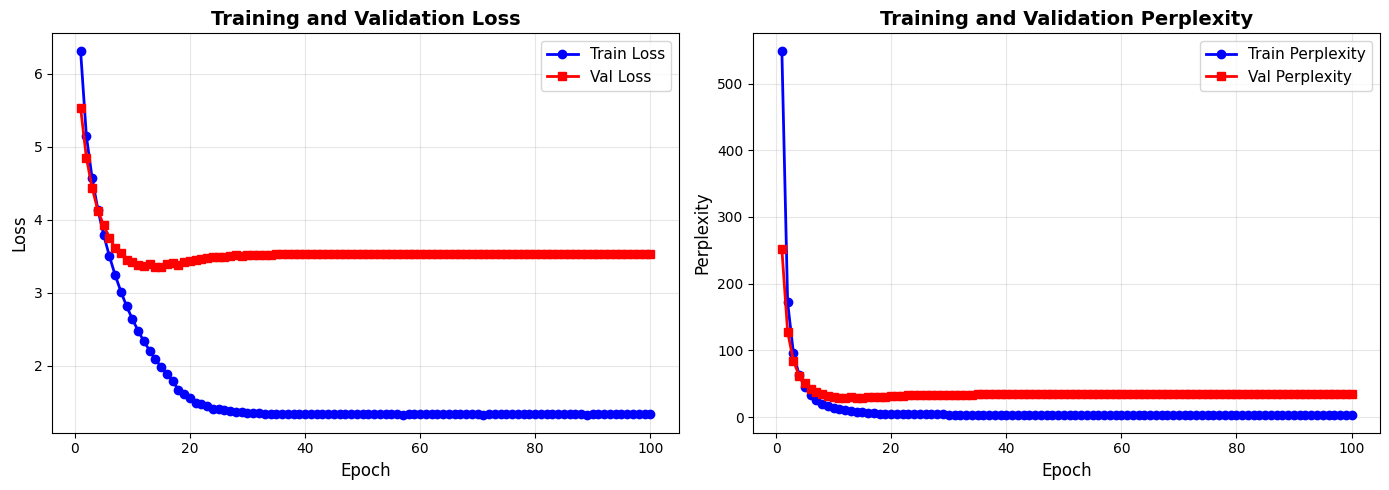

✓ Training curves saved to 'training_curves.png'


In [ ]:
print("\n" + "=" * 70)
print("VISUALIZING RESULTS")
print("=" * 70)

plt.figure(figsize=(14, 5))

# Loss plot
plt.subplot(1, 2, 1)
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, 'bo-', label='Train Loss', linewidth=2, markersize=6)
plt.plot(epochs, val_losses, 'rs-', label='Val Loss', linewidth=2, markersize=6)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Perplexity plot
plt.subplot(1, 2, 2)
train_ppls = [math.exp(loss) for loss in train_losses]
val_ppls = [math.exp(loss) for loss in val_losses]
plt.plot(epochs, train_ppls, 'bo-', label='Train Perplexity', linewidth=2, markersize=6)
plt.plot(epochs, val_ppls, 'rs-', label='Val Perplexity', linewidth=2, markersize=6)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Perplexity', fontsize=12)
plt.title('Training and Validation Perplexity', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training curves saved to 'training_curves.png'")

In [ ]:
print("\n" + "=" * 70)
print("SAVING RESULTS")
print("=" * 70)

# Save results
results = {
    'test_loss': test_loss,
    'test_perplexity': test_ppl,
    'bleu_score': bleu_score,
    'config': config,
    'vocab_sizes': {
        'en': en_tokenizer.get_vocab_size(),
        'vi': vi_tokenizer.get_vocab_size()
    },
    'training_time': total_time,
    'train_losses': train_losses,
    'val_losses': val_losses
}

with open('results.pkl', 'wb') as f:
    pickle.dump(results, f)

# Save tokenizers
en_tokenizer.save('en_tokenizer.pkl')
vi_tokenizer.save('vi_tokenizer.pkl')

print("✓ Results saved to 'results.pkl'")
print("✓ Tokenizers saved to 'en_tokenizer.pkl' and 'vi_tokenizer.pkl'")
print("✓ Best model saved to 'best_model.pt'")


SAVING RESULTS
✓ Results saved to 'results.pkl'
✓ Tokenizers saved to 'en_tokenizer.pkl' and 'vi_tokenizer.pkl'
✓ Best model saved to 'best_model.pt'


In [ ]:
print("\n" + "=" * 70)
print("FINAL TRANSLATION QUALITY REPORT")
print("=" * 70)

print(f"\n📊 Model Performance:")
print(f"  {'Metric':<20} {'Value':<15}")
print(f"  {'-'*35}")
print(f"  {'Test Loss':<20} {test_loss:<15.4f}")
print(f"  {'Test Perplexity':<20} {test_ppl:<15.2f}")
print(f"  {'BLEU Score':<20} {bleu_score:<15.2f}")

print(f"\n📐 Model Size:")
print(f"  {'EN Vocabulary':<20} {en_tokenizer.get_vocab_size():<15,}")
print(f"  {'VI Vocabulary':<20} {vi_tokenizer.get_vocab_size():<15,}")
print(f"  {'Parameters':<20} {total_params:<15,}")

print(f"\n⏱️  Training Time:")
print(f"  {'Total Time':<20} {total_time/60:<15.2f} minutes")
print(f"  {'Avg per Epoch':<20} {total_time/config['num_epochs']/60:<15.2f} minutes")

print("\n✅ Training Complete!")


FINAL TRANSLATION QUALITY REPORT

📊 Model Performance:
  Metric               Value          
  -----------------------------------
  Test Loss            3.5252         
  Test Perplexity      33.96          
  BLEU Score           14.91          

📐 Model Size:
  EN Vocabulary        30,560         
  VI Vocabulary        13,154         
  Parameters           18,526,050     

⏱️  Training Time:
  Total Time           98.25           minutes
  Avg per Epoch        0.98            minutes

✅ Training Complete!


In [ ]:
print("\n" + "=" * 70)
print("INTERACTIVE TRANSLATION")
print("=" * 70)
print("Enter English sentences to translate to Vietnamese")
print("Type 'quit', 'exit', or 'q' to stop\n")

while True:
    sentence = input("🇬🇧 EN: ").strip()

    if sentence.lower() in ['quit', 'exit', 'q', '']:
        print("👋 Goodbye!")
        break

    try:
        translation = translate_sentence(model, sentence, en_tokenizer, vi_tokenizer)
        print(f"🇻🇳 VI: {translation}\n")
    except Exception as e:
        print(f"❌ Error: {e}\n")


INTERACTIVE TRANSLATION
Enter English sentences to translate to Vietnamese
Type 'quit', 'exit', or 'q' to stop

